In [3]:
#importing the required stuff

from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.applications import OptimizationApplication
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt
import datetime


In [4]:
%matplotlib inline
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import *
import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [5]:
# set number of assets (= number of qubits)
num_assets = 10
seed = 1234
#### Using data from yahoo finance
data = YahooDataProvider(
        tickers= ["JPM", "GS", "MSFT", "AAPL", "CO", "WMT", "DIS", "BA", "MCD", "NKE"],
        start=datetime.datetime(2011, 1, 1),
        end=datetime.datetime(2021, 12, 31),
    )
data.run()

mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()


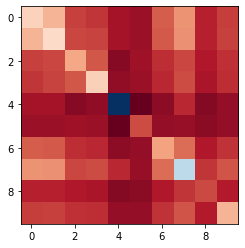

In [6]:
# plot sigma
plt.imshow(sigma, interpolation="nearest", cmap = "RdBu")
plt.show()


In [7]:
print(mu)
print('\n')
print(sigma)

[0.00074142 0.00052238 0.00111593 0.00120323 0.00042029 0.0005188
 0.000685   0.00074758 0.00063684 0.00092744]


[[3.15951698e-04 2.72680573e-04 1.35259520e-04 1.23269349e-04
  7.62573867e-05 6.42314621e-05 1.65496276e-04 2.28801059e-04
  9.82612336e-05 1.32708093e-04]
 [2.72680573e-04 3.32898185e-04 1.42804012e-04 1.37727384e-04
  7.60256330e-05 6.43537029e-05 1.63794221e-04 2.25252682e-04
  9.74010339e-05 1.33772253e-04]
 [1.35259520e-04 1.42804012e-04 2.54327934e-04 1.59721346e-04
  4.30251452e-05 7.08601920e-05 1.14307331e-04 1.42913199e-04
  8.91314948e-05 1.17166313e-04]
 [1.23269349e-04 1.37727384e-04 1.59721346e-04 3.14865556e-04
  5.21770838e-05 6.39306451e-05 1.05680855e-04 1.48933295e-04
  8.14091277e-05 1.11827416e-04]
 [7.62573867e-05 7.60256330e-05 4.30251452e-05 5.21770838e-05
  8.10942073e-04 8.25613718e-06 5.00759599e-05 1.07748679e-04
  4.05202291e-05 5.54877485e-05]
 [6.42314621e-05 6.43537029e-05 7.08601920e-05 6.39306451e-05
  8.25613718e-06 1.46244389e-04 5.71038

In [8]:
q = 0.5  # set risk factor
budget = num_assets // 10  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

portfolio = PortfolioOptimization(
    expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget
)
qp = portfolio.to_quadratic_program()
qp


<QuadraticProgram: minimize 0.00015797584912752264*x_0^2 + 0.00027268057294895..., 10 variables, 1 constraints, 'Portfolio optimization'>

In [9]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i] == "1" else 0 for i in reversed(range(num_assets))])
    return x


def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector) ** 2
    i_sorted = reversed(np.argsort(probabilities))
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        # value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        print("%10s\t%.4f\t\t%.4f" % (x, value, probability))

In [10]:
#classical reference solution

exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 0 0 0 0 0 0]	-0.0010		1.0000
[1 1 1 1 1 1 1 1 1 1]	82.1399		0.0000
[0 0 0 0 1 0 1 0 1 0]	4.0554		0.0000
[1 0 1 1 1 0 1 0 1 0]	25.3498		0.0000
[0 0 1 1 1 0 1 0 1 0]	16.2230		0.0000
[1 1 0 1 1 0 1 0 1 0]	25.3506		0.0000
[0 1 0 1 1 0 1 0 1 0]	16.2237		0.0000
[1 0 0 1 1 0 1 0 1 0]	16.2235		0.0000
[0 0 0 1 1 0 1 0 1 0]	9.1250		0.0000
[1 1 1 0 1 0 1 0 1 0]	25.3507		0.0000
[0 1 1 0 1 0 1 0 1 0]	16.2238		0.0000
[1 0 1 0 1 0 1 0 1 0]	16.2235		0.0000
[0 0 1 0 1 0 1 0 1 0]	9.1251		0.0000
[1 1 0 0 1 0 1 0 1 0]	16.2244		0.0000
[0 1 0 0 1 0 1 0 1 0]	9.1258		0.0000
[1 0 0 0 1 0 1 0 1 0]	9.1256		0.0000
[1 1 1 1 0 0 1 0 1 0]	25.3500		0.0000
[1 1 1 1 1 0 1 0 1 0]	36.5052		0.0000
[0 1 1 1 0 0 1 0 1 0]	16.2230		0.0000
[1 0 1 1 0 0 1 0 1 0]	16.2228		0.0000
[0 0 1 1 0 0 1 0 1 0]	9.1242		0.0000
[1 1 0 1

In [11]:
#### VQE solution
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
vqe_mes = VQE(ry, optimizer=cobyla, quantum_instance=quantum_instance)
vqe = MinimumEigenOptimizer(vqe_mes)
result = vqe.solve(qp)

print_result(result)


c:\Users\shrey\AppData\Local\Programs\Python\Python310\lib\site-packages\qiskit_optimization\algorithms\optimization_algorithm.py:138: UserWarning: The sum of probability of samples is not close to 1: f{sum_prob}
  warn("The sum of probability of samples is not close to 1: f{sum_prob}")


Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 1 0 0 0 0 0 0 0 0]	-0.0004		0.5827
[0 0 0 0 0 0 1 0 0 0]	-0.0006		0.4102
[0 1 0 0 0 0 0 1 0 0]	1.0135		0.0014
[0 0 0 0 0 0 1 1 0 0]	1.0132		0.0008
[1 0 0 0 0 0 1 0 0 0]	1.0131		0.0006
[0 1 0 0 0 0 0 0 0 1]	1.0131		0.0005
[0 0 0 1 0 0 1 0 0 0]	1.0126		0.0005
[0 1 0 1 0 0 0 0 0 0]	1.0128		0.0003
[0 1 1 0 0 0 0 0 0 0]	1.0129		0.0003
[0 0 0 0 1 0 0 0 0 0]	-0.0000		0.0002
[0 1 0 0 1 0 1 0 0 0]	4.0557		0.0002
[0 0 0 0 0 0 0 0 0 0]	1.0141		0.0002
[0 0 1 0 0 0 0 0 0 0]	-0.0010		0.0002
[1 0 0 0 0 0 0 0 0 0]	-0.0006		0.0002
[1 1 0 0 0 0 0 0 0 0]	1.0134		0.0002
[0 0 0 0 0 0 1 0 0 1]	1.0129		0.0002
[1 0 0 0 0 0 0 0 1 0]	1.0130		0.0001
[0 1 0 0 1 0 0 0 0 0]	1.0138		0.0001
[0 1 1 0 0 0 1 0 0 0]	4.0549		0.0001
[1 1 0 0 0 0 0 0 1 0]	4.0553		0.0001
[0 0 1 0 0 0 1 0 0 0]	1.0126		0.0001
[0 0 0 0 0 1 0 0 0

In [12]:
#### QAOA solution

algorithm_globals.random_seed = 1234
backend = Aer.get_backend("statevector_simulator")

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3, quantum_instance=quantum_instance)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)



Optimal: selection [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], value -0.0010

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 0 0 0 0]	1.0141		0.2470
[0 0 0 1 0 0 0 0 0 0]	-0.0010		0.0602
[0 0 0 0 0 1 0 0 0 0]	-0.0004		0.0602
[0 0 1 0 0 0 0 0 0 0]	-0.0010		0.0602
[0 0 0 0 0 0 0 0 1 0]	-0.0006		0.0601
[0 0 0 0 0 0 0 0 0 1]	-0.0008		0.0601
[0 0 0 0 1 0 0 0 0 0]	-0.0000		0.0600
[0 0 0 0 0 0 1 0 0 0]	-0.0006		0.0600
[1 0 0 0 0 0 0 0 0 0]	-0.0006		0.0599
[0 0 0 0 0 0 0 1 0 0]	-0.0005		0.0598
[0 1 0 0 0 0 0 0 0 0]	-0.0004		0.0598
[0 0 1 1 0 0 0 0 0 0]	1.0122		0.0034
[0 0 0 1 0 1 0 0 0 0]	1.0127		0.0034
[0 0 0 1 0 0 0 0 0 1]	1.0124		0.0034
[0 0 1 0 0 1 0 0 0 0]	1.0127		0.0033
[0 0 0 1 0 0 0 0 1 0]	1.0126		0.0033
[0 0 1 0 0 0 0 0 0 1]	1.0124		0.0033
[0 0 1 0 0 0 0 0 1 0]	1.0126		0.0033
[0 0 0 0 0 1 0 0 0 1]	1.0129		0.0033
[0 0 0 0 0 1 0 0 1 0]	1.0131		0.0033
[0 0 0 0 0 0 0 0 1 1]	1.0128		0.0033
[0 0 0 1 0 0 

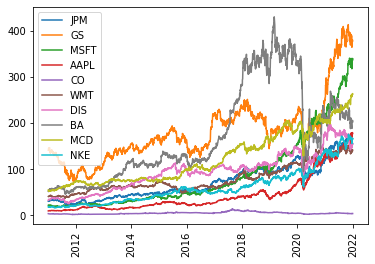

In [13]:
stocks = ["JPM", "GS", "V", "UNH", "CO"]

token = "NBQ7j3g_Q8_bcpvW6kMA"
if token != "NBQ7j3g_Q8_bcpvW6kMA":
    try:
        wiki = WikipediaDataProvider(
            token=token,
            tickers=stocks,
            start=datetime.datetime(2011, 1, 1),
            end=datetime.datetime(2021, 12, 31),
        )
        wiki.run()
    except QiskitFinanceError as ex:
        print(ex)
        print("Error retrieving data.")


if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        if wiki._n <= 1:
            print(
                "Not enough wiki data to plot covariance or time-series similarity. Please use at least two tickers."
            )
        else:
            rho = wiki.get_similarity_matrix()
            print("A time-series similarity measure:")
            print(rho)
            plt.imshow(rho)
            plt.show()

            cov = wiki.get_covariance_matrix()
            print("A covariance matrix:")
            print(cov)
            plt.imshow(cov)
            plt.show()
    else:
        print("No wiki data loaded.")

if token != "NBQ7j3g_Q8_bcpvW6kMA":
    if wiki._data:
        print("The underlying evolution of stock prices:")
        for (cnt, s) in enumerate(stocks):
            plt.plot(wiki._data[cnt], label=s)
        plt.legend()
        plt.xticks(rotation=90)
        plt.show()

        for (cnt, s) in enumerate(stocks):
            print(s)
            print(wiki._data[cnt])
    else:
        print("No wiki data loaded.")

for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.xticks(rotation=90)
plt.show()